In [2]:
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#define amount of sample points
N = 2000

In [4]:
def thermal_conductivity_equation(x):
    return (2 + torch.exp(-4*(torch.pi**2)*x[0])*torch.sin(2*torch.pi*x[1]) + torch.exp(-16*(torch.pi**2)*x[0])*torch.cos(4*torch.pi*x[1]))

# function depicting a real graph and a predicted one
def check_current_situation(cur_model):
    x = torch.linspace(0, 1, 100)
    time = torch.zeros(100)
    real_temp = thermal_conductivity_equation([time, x])

    test_points = torch.stack((x, time), axis = -1)

    pinn_temp = cur_model(test_points)

    plt.plot(x.detach(), pinn_temp.detach())
    plt.plot(x, real_temp)

    plt.plot()
    plt.show()

In [5]:
x_physics = torch.rand(N).requires_grad_(True)
time_physics = 0.05 * torch.rand(N).requires_grad_(True)

points_for_pinn_model = torch.stack((time_physics, x_physics), -1)
boundary_condition_points = torch.stack((torch.zeros(N), x_physics), -1)

torch.manual_seed(123)
thermal_conductivity_equation([time_physics, x_physics])

tensor([2.0842, 2.3055, 2.0071,  ..., 2.3550, 1.4340, 1.7137],
       grad_fn=<AddBackward0>)

In [6]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer = 2, hidden_layer = 32, number_layers = 3, output_layer = 1):
        super().__init__()
        
        activation = nn.Tanh
        
        self.fcs = nn.Sequential(*
            [
                nn.Linear(input_layer, hidden_layer),
                activation()
            ]
        )
        
        self.fch = nn.Sequential(*
            [
                nn.Sequential(*
                    [
                        nn.Linear(hidden_layer, hidden_layer),
                        activation()
                    ]
                ) for _ in range(number_layers - 1)
            ]
        )
        
        self.fce = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        
        return x

In [7]:
pinn_model = PINN()
optimizer = torch.optim.SGD(pinn_model.parameters(), lr=0.01)
#optimizer = torch.optim.Adam(pinn_model.parameters(), lr = 0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5000, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor = 0.7)

epoch: 0	loss: (9.616948127746582, 4.364195346832275, 5.252630710601807, 0.00012178389442851767)	


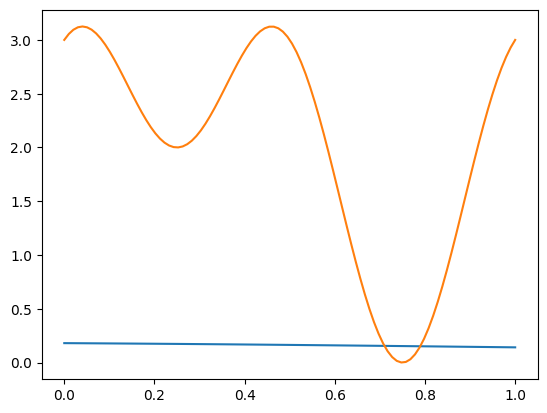

epoch: 250	loss: (0.8674100637435913, 0.10216940194368362, 0.7550292611122131, 0.01021142303943634)	
epoch: 500	loss: (0.849897027015686, 0.11378621309995651, 0.7354793548583984, 0.0006314241327345371)	
epoch: 750	loss: (0.8471724987030029, 0.11577503383159637, 0.7312365174293518, 0.00016093440353870392)	
epoch: 1000	loss: (0.8456711173057556, 0.11593165248632431, 0.7294231653213501, 0.00031629973091185093)	


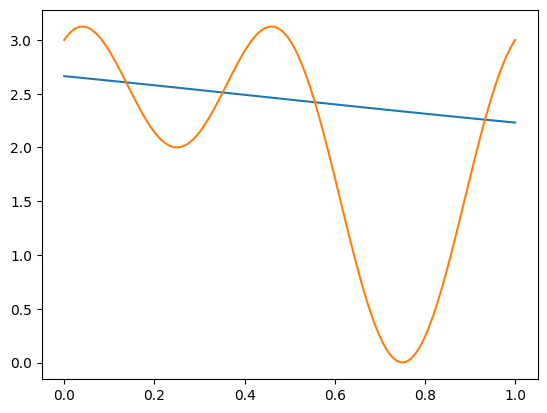

epoch: 1250	loss: (0.8446351885795593, 0.11589644849300385, 0.7282010316848755, 0.0005377002526074648)	
epoch: 1500	loss: (0.8438074588775635, 0.11584816873073578, 0.727252185344696, 0.0007071089930832386)	
epoch: 1750	loss: (0.8430784940719604, 0.11581237614154816, 0.7264562249183655, 0.0008099076221697032)	
epoch: 2000	loss: (0.8424035310745239, 0.11579029262065887, 0.725752592086792, 0.0008606389164924622)	


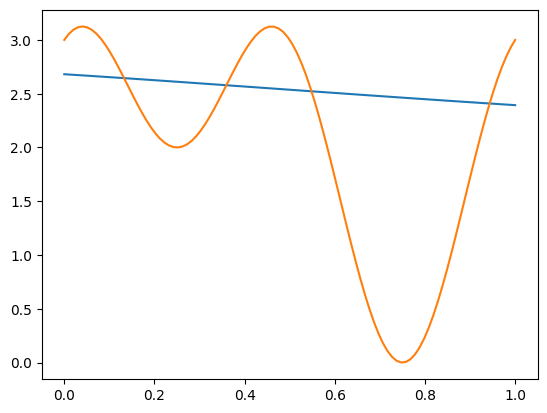

epoch: 2250	loss: (0.8417631387710571, 0.1157783716917038, 0.7251085042953491, 0.0008762224460951984)	
epoch: 2500	loss: (0.8411476016044617, 0.11577307432889938, 0.7245052456855774, 0.0008692521951161325)	
epoch: 2750	loss: (0.84055095911026, 0.11577169597148895, 0.7239312529563904, 0.0008480068645440042)	
epoch: 3000	loss: (0.839968740940094, 0.11577244848012924, 0.7233786582946777, 0.0008176699629984796)	


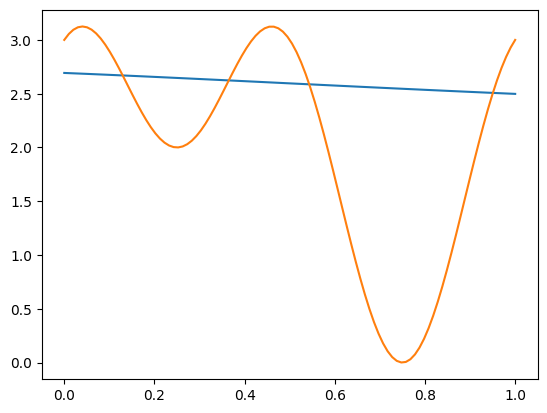

epoch: 3250	loss: (0.8393974304199219, 0.11577415466308594, 0.7228417992591858, 0.0007814705604687333)	
epoch: 3500	loss: (0.838833749294281, 0.11577599495649338, 0.722316324710846, 0.0007414062274619937)	
epoch: 3750	loss: (0.8382749557495117, 0.11577737331390381, 0.7217987775802612, 0.0006987964734435081)	
epoch: 4000	loss: (0.83771812915802, 0.11577776819467545, 0.721285879611969, 0.0006544804200530052)	


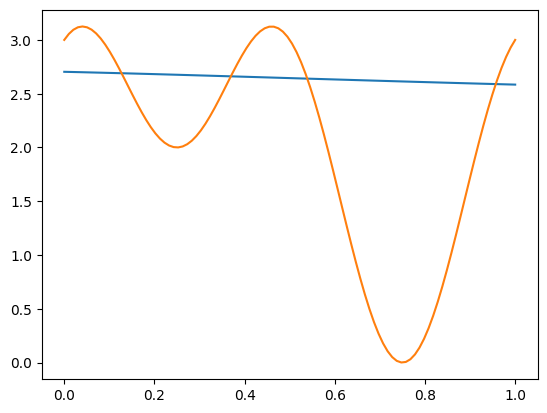

epoch: 4250	loss: (0.8371609449386597, 0.11577680706977844, 0.7207749485969543, 0.0006091553950682282)	
epoch: 4500	loss: (0.836600661277771, 0.11577388644218445, 0.7202632427215576, 0.0005635081906802952)	
epoch: 4750	loss: (0.8360348343849182, 0.11576835811138153, 0.7197480201721191, 0.000518426822964102)	
epoch: 5000	loss: (0.8354613780975342, 0.11575961112976074, 0.719226598739624, 0.00047516499762423337)	


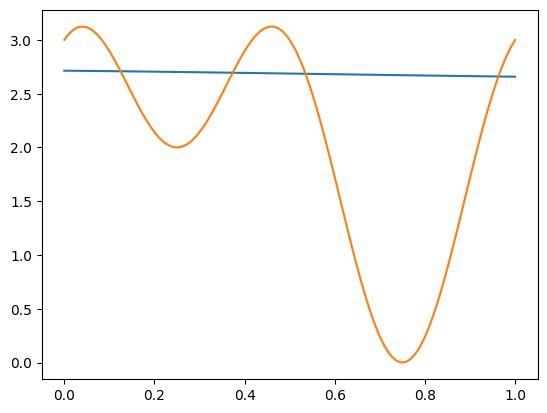

epoch: 5250	loss: (0.83487868309021, 0.11574670672416687, 0.7186964750289917, 0.00043545954395085573)	
epoch: 5500	loss: (0.8342852592468262, 0.11572889238595963, 0.718154788017273, 0.0004015768936369568)	
epoch: 5750	loss: (0.833681046962738, 0.11570525914430618, 0.7175995707511902, 0.0003762274864129722)	
epoch: 6000	loss: (0.8330661058425903, 0.11567528545856476, 0.7170284986495972, 0.00036233721766620874)	


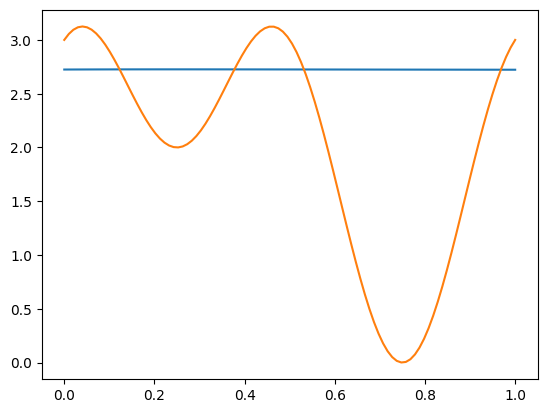

epoch: 6250	loss: (0.8324421048164368, 0.1156386137008667, 0.7164407968521118, 0.0003627007536124438)	
epoch: 6500	loss: (0.8318108320236206, 0.11559521406888962, 0.7158359289169312, 0.000379664299543947)	
epoch: 6750	loss: (0.831174910068512, 0.11554539948701859, 0.7152146100997925, 0.0004149146261624992)	
epoch: 7000	loss: (0.8305371999740601, 0.1154896467924118, 0.7145780920982361, 0.00046942185144871473)	


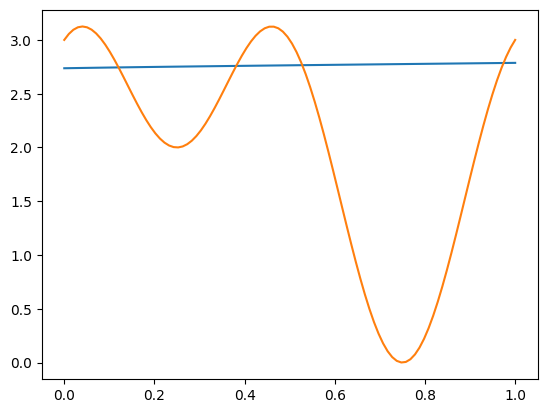

epoch: 7250	loss: (0.829900324344635, 0.11542809009552002, 0.7139288187026978, 0.0005434363265521824)	
epoch: 7500	loss: (0.8292667269706726, 0.11536065489053726, 0.7132697105407715, 0.00063635956030339)	
epoch: 7750	loss: (0.8286369442939758, 0.11528649926185608, 0.7126039266586304, 0.0007465220405720174)	
epoch: 8000	loss: (0.8280097246170044, 0.11520376056432724, 0.7119349837303162, 0.0008710168767720461)	


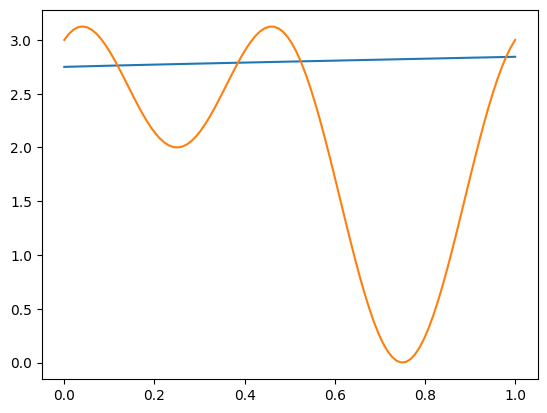

epoch: 8250	loss: (0.8273814916610718, 0.11510957032442093, 0.7112659811973572, 0.0010059521300718188)	
epoch: 8500	loss: (0.8267468214035034, 0.1149996966123581, 0.7105997800827026, 0.0011473054764792323)	
epoch: 8750	loss: (0.8260995149612427, 0.11486899852752686, 0.7099382281303406, 0.001292280969209969)	
epoch: 9000	loss: (0.8254345655441284, 0.11471211165189743, 0.7092816233634949, 0.0014408110873773694)	


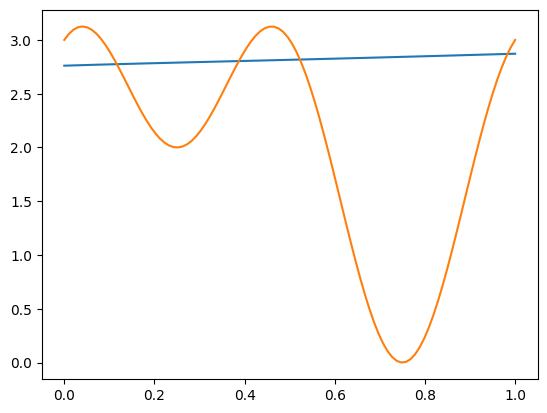

epoch: 9250	loss: (0.8247494697570801, 0.11452449858188629, 0.7086287140846252, 0.0015962985344231129)	
epoch: 9500	loss: (0.8240454792976379, 0.11430361866950989, 0.7079768180847168, 0.0017650530207902193)	
epoch: 9750	loss: (0.8233259916305542, 0.11404994875192642, 0.7073217034339905, 0.0019542903173714876)	
epoch: 10000	loss: (0.8225956559181213, 0.11376669257879257, 0.7066596150398254, 0.002169382991269231)	


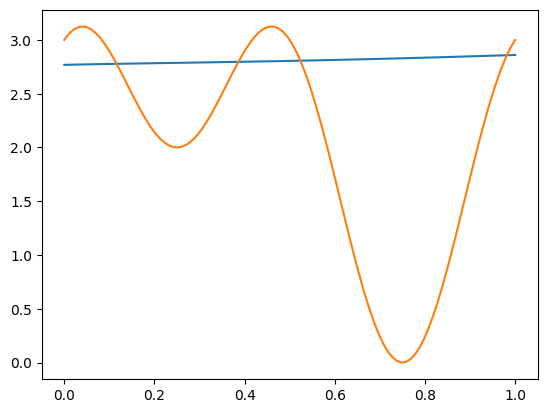

epoch: 10250	loss: (0.8218580484390259, 0.11345873773097992, 0.7059875130653381, 0.0024117741268128157)	
epoch: 10500	loss: (0.8211145401000977, 0.11313097178936005, 0.7053049802780151, 0.0026785489171743393)	
epoch: 10750	loss: (0.8203645348548889, 0.11278717964887619, 0.7046135663986206, 0.002963756211102009)	
epoch: 11000	loss: (0.8196056485176086, 0.11242975294589996, 0.703915536403656, 0.0032603638246655464)	


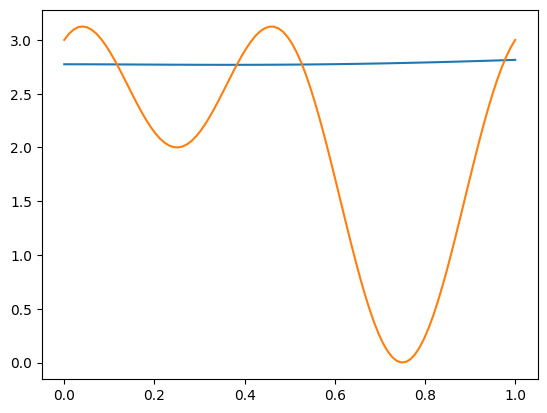

epoch: 11250	loss: (0.8188351988792419, 0.11206023395061493, 0.7032129764556885, 0.0035619507543742657)	
epoch: 11500	loss: (0.8185951113700867, 0.1117100939154625, 0.7035516500473022, 0.0033334025647491217)	
epoch: 11750	loss: (0.8177692294120789, 0.11146890372037888, 0.7025500535964966, 0.0037502823397517204)	
epoch: 12000	loss: (0.8174649477005005, 0.11119376122951508, 0.7026527523994446, 0.0036184226628392935)	


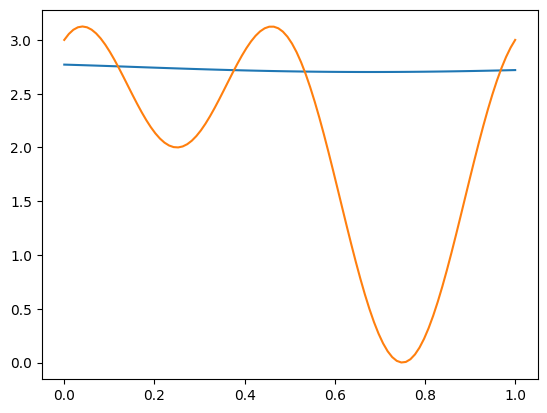

epoch: 12250	loss: (0.8208340406417847, 0.11251378804445267, 0.7027803659439087, 0.005539868958294392)	
epoch: 12500	loss: (0.8162160515785217, 0.11070950329303741, 0.7014822959899902, 0.004024243913590908)	
epoch: 12750	loss: (0.8158020973205566, 0.11047104746103287, 0.7013459801673889, 0.003985033370554447)	
epoch: 13000	loss: (0.8351483941078186, 0.11652442812919617, 0.70720374584198, 0.011420204304158688)	


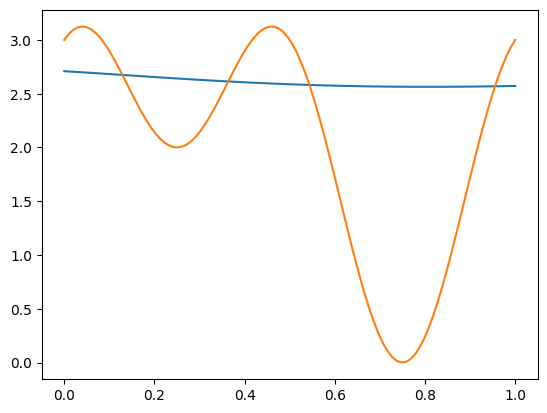

epoch: 13250	loss: (0.8202627897262573, 0.11216823011636734, 0.7014365792274475, 0.006657938472926617)	
epoch: 13500	loss: (0.8143966197967529, 0.11006150394678116, 0.6995630860328674, 0.004771988373249769)	
epoch: 13750	loss: (0.8135931491851807, 0.1097419336438179, 0.6990578770637512, 0.004793368745595217)	
epoch: 14000	loss: (0.8131839632987976, 0.10961481928825378, 0.698584794998169, 0.0049843196757137775)	


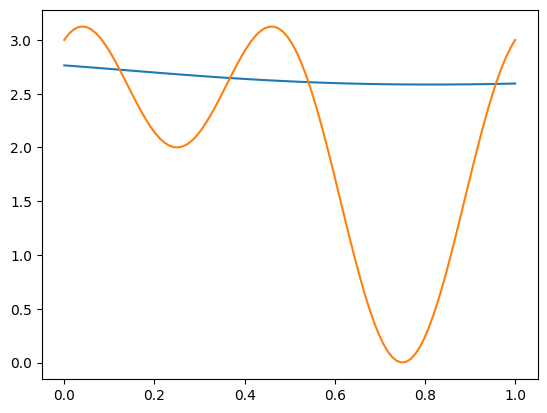

epoch: 14250	loss: (0.8135764598846436, 0.10981294512748718, 0.6982462406158447, 0.005517215002328157)	
epoch: 14500	loss: (0.8188339471817017, 0.11162315309047699, 0.6991239190101624, 0.008086888119578362)	
epoch: 14750	loss: (0.8366678953170776, 0.11697457730770111, 0.7035104632377625, 0.016182830557227135)	
epoch: 15000	loss: (0.8171675801277161, 0.1109422817826271, 0.6980680227279663, 0.00815725326538086)	


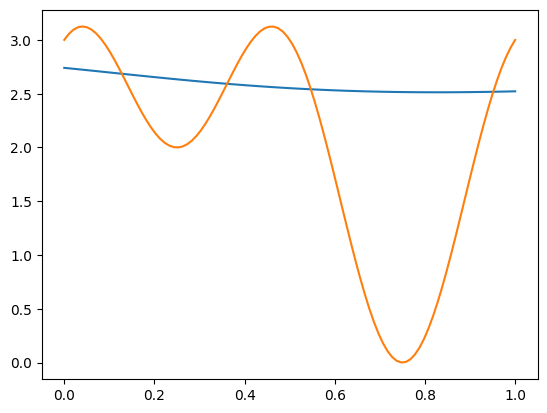

epoch: 15250	loss: (0.8108794689178467, 0.10898805409669876, 0.6959303021430969, 0.00596114294603467)	
epoch: 15500	loss: (0.8137896656990051, 0.10995882004499435, 0.6956222653388977, 0.008208555169403553)	
epoch: 15750	loss: (0.8232855796813965, 0.11204475164413452, 0.696479856967926, 0.014760991558432579)	
epoch: 16000	loss: (0.8111230731010437, 0.10897649079561234, 0.6934378743171692, 0.008708729408681393)	


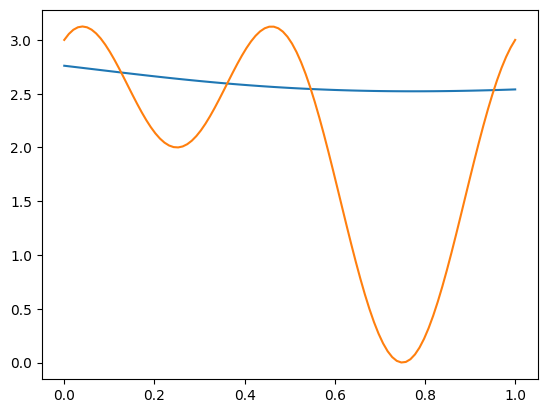

epoch: 16250	loss: (0.8228089213371277, 0.11016441136598587, 0.6923738718032837, 0.02027066983282566)	
epoch: 16500	loss: (0.8140102028846741, 0.10873197764158249, 0.6909506320953369, 0.01432759128510952)	
epoch: 16750	loss: (0.8165802955627441, 0.10867483168840408, 0.6901185512542725, 0.01778692752122879)	
epoch: 17000	loss: (0.8160057663917542, 0.10865405201911926, 0.6896322965621948, 0.017719443887472153)	


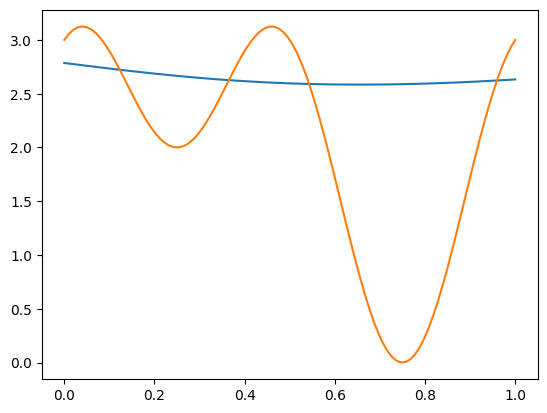

epoch: 17250	loss: (0.8147215247154236, 0.10861321538686752, 0.6894111037254333, 0.016697242856025696)	
epoch: 17500	loss: (0.8142768740653992, 0.1086016520857811, 0.6892083287239075, 0.01646689884364605)	
epoch: 17750	loss: (0.813966691493988, 0.10855668783187866, 0.6889823079109192, 0.016427669674158096)	
epoch: 18000	loss: (0.813628613948822, 0.10844726860523224, 0.6887058019638062, 0.016475573182106018)	


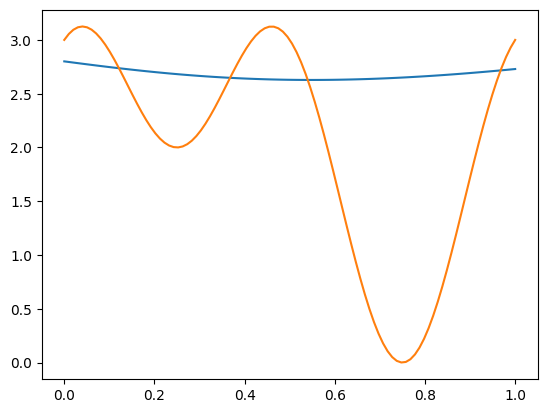

epoch: 18250	loss: (0.813313364982605, 0.10829388350248337, 0.688387930393219, 0.016631513833999634)	
epoch: 18500	loss: (0.8130096793174744, 0.10814275592565536, 0.6880794763565063, 0.016787465661764145)	
epoch: 18750	loss: (0.8126381039619446, 0.10807084292173386, 0.6878870725631714, 0.016680195927619934)	
epoch: 19000	loss: (0.8120898008346558, 0.10859277099370956, 0.6885501146316528, 0.014946924522519112)	


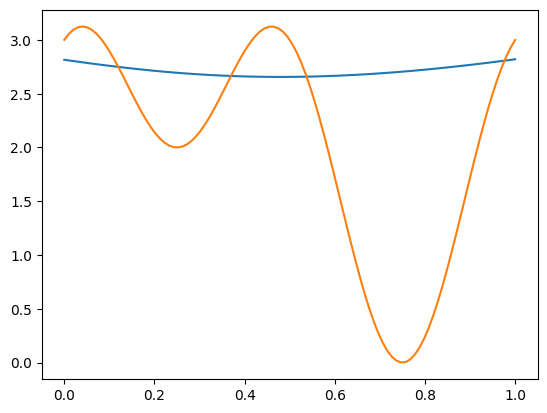

epoch: 19250	loss: (0.8259775638580322, 0.10758852958679199, 0.6867948174476624, 0.03159423917531967)	
epoch: 19500	loss: (0.8131362795829773, 0.10738380253314972, 0.6867108345031738, 0.019041642546653748)	
epoch: 19750	loss: (0.8112305402755737, 0.10741381347179413, 0.6867450475692749, 0.017071686685085297)	


In [8]:
epochs = 20000


for cur_epoch in range(epochs):
    optimizer.zero_grad()
    
    boundary_condition_temp = pinn_model(boundary_condition_points)
    network_temp = pinn_model(points_for_pinn_model)
    
    # compute the "data loss"
    loss1 = torch.mean((thermal_conductivity_equation([time_physics, x_physics]).view(-1,1) - network_temp)**2)
    loss2 = torch.mean((thermal_conductivity_equation([torch.zeros_like(x_physics), x_physics]).view(-1,1) - boundary_condition_temp)**2)
    
    network_temp = pinn_model(points_for_pinn_model)
    
    dt = torch.autograd.grad(network_temp, time_physics, torch.ones_like(network_temp), create_graph=True)[0]

    # computes dy/dx
    dx = torch.autograd.grad(network_temp, x_physics, torch.ones_like(network_temp), create_graph=True)[0]
    
    # computes d^2y/dx^2
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]
    
    # compute the "physics loss"
    loss3 = torch.mean((dt - dx2)**2)
    
    
    loss = loss1 + loss2 + loss3
    loss.backward(retain_graph=True)
    
    optimizer.step()
    
    if cur_epoch % 250 == 0:
        print(f'epoch: {cur_epoch}\tloss: {float(loss.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy()), float(loss3.detach().numpy())}\t')
    if cur_epoch % 1000 == 0:
        check_current_situation(pinn_model) 

In [42]:
pinn_model(points_for_pinn_model)

tensor([[2.0062],
        [2.0194],
        [2.0054],
        ...,
        [2.0142],
        [2.0238],
        [2.0115]], grad_fn=<AddmmBackward0>)

In [47]:
torch.mean(thermal_conductivity_equation([time_physics, x_physics]).view(-1,1) - pinn_model(points_for_pinn_model))

tensor(-0.0220, grad_fn=<MeanBackward0>)

In [46]:
thermal_conductivity_equation([time_physics, x_physics]).view(-1,1)


tensor([[2.1422],
        [1.9769],
        [2.2335],
        ...,
        [1.8930],
        [2.6954],
        [1.9622]], grad_fn=<ViewBackward0>)

In [48]:
torch.zeros_like(x_physics)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [49]:
x_physics

tensor([0.2961, 0.5166, 0.2517,  ..., 0.9463, 0.4930, 0.9744],
       requires_grad=True)